In [51]:
# Python ≥3.5 is required

import sys

assert sys.version_info >= (3, 5)


# Scikit-Learn ≥0.20 is required

import sklearn

assert sklearn.__version__ >= "0.20"


try:

  # %tensorflow_version only exists in Colab.

  %tensorflow_version 2.x

  IS_COLAB = True

except Exception:

  IS_COLAB = False


# TensorFlow ≥2.0 is required

import tensorflow as tf

from tensorflow import keras

assert tf.__version__ >= "2.0"


if not tf.config.list_physical_devices('GPU'):

  print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

  if IS_COLAB:

    print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


# Common imports

import numpy as np

import os

from pathlib import Path


# to make this notebook's output stable across runs

np.random.seed(42)

tf.random.set_seed(42)


# To plot pretty figures

%matplotlib inline

import matplotlib as mpl

import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)

mpl.rc('xtick', labelsize=12)

mpl.rc('ytick', labelsize=12)


# Where to save the figures

PROJECT_ROOT_DIR = "."

CHAPTER_ID = "rnn"

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):

  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)

  print("Saving figure", fig_id)

  if tight_layout:

    plt.tight_layout()

  plt.savefig(path, format=fig_extension, dpi=resolution)



No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [52]:
def generate_time_series(batch_size, n_steps):  
  freq1, freq2, offsets1, offsets2 = np.random.rand(4,batch_size,1)
  time = np.linspace(0,1,n_steps)
  series = 0.5 * np.sin((time - offsets1)*(freq1*10 + 10)) # wave1
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave2
  series += 0.1 * (np.random.rand(batch_size, n_steps) -0.5) # + noise
  return series[..., np.newaxis].astype(np.float32)

진폭이 같고 진동 수와 위상이 랜덤한 두 개의 사인 곡선을 더하고 약간의 잡음을 추가

In [53]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000,:n_steps], series[7000:9000,-1]
X_test, y_test = series[9000:, n_steps], series[9000:,-1]

In [54]:
X_train.shape

(7000, 50, 1)

Saving figure time_series_plot


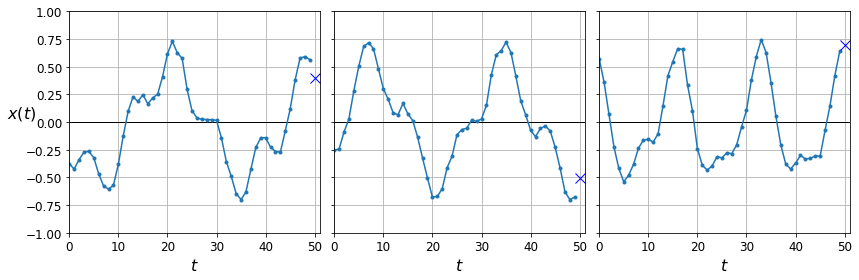

In [55]:
def plot_series(series, y=None, y_pred=None, x_label="$t$",
                y_label="$x(t)$"):
  plt.plot(series, ".-")
  if y is not None:
    plt.plot(n_steps, y, "bx", markersize=10)
  if y_pred is not None:
    plt.plot(n_steps, y_pred, "ro")
  plt.grid(True)
  if x_label:
    plt.xlabel(x_label, fontsize=16)
  if y_label:
    plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.hlines(0,0,100, linewidth=1)
  plt.axis([0, n_steps +1, -1, 1])

fig,axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4))
for col in range(3):
  plt.sca(axes[col])
  plot_series(X_valid[col,:,0], y_valid[col,0],
              y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

각 시계열의 마지막 값을 그대로 예측 -> 순진한 예측

MSE = 0.020

In [56]:
y_pred = X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

완전 연결 네트워크 사용

시계열 값의 선형 조합으로 예측

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)                        
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0062

In [58]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 789us/step - loss: 0.0042


0.004168086685240269

MSE = 0.004

순진한 예측보다는 좋음

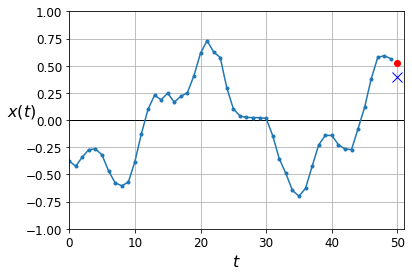

In [59]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])
plt.show()

## 간단한 RNN

- 순환신경망은 어떤 길의의 타임 스텝도 처리할 수 있기 때문에 입력 시퀀스의 길이를 지정할 필요가 없으므로 입력차원을 None으로 지정
- 기본적으로 하이퍼볼릭 탄젠트 활성화 함수 사용

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None,1])                                 
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0116 - val_loss: 0.0110

In [61]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0109


0.010881561785936356

MSE = 0.010으로 간단한 선형 모델을 앞지르지 못함

세개의 파라미터 밖의 가지지 못하기 때문
-> RNN을 여러 층으로 쌓음(deep RNN)

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)      
])

model.compile(loss="mse", optimizer="adam") 
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))                      


Epoch 1/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0035 - val_lo

In [63]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0029


0.0029105658177286386

MSE = 0.0029 로 선형모델 보다 좋아짐

In [64]:
np.random.seed(42)

tf.random.set_seed(42)


model = keras.models.Sequential([

    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),

    keras.layers.SimpleRNN(20),

    keras.layers.Dense(1) # 마지막 층 변화

])


model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train, y_train, epochs=20,

validation_data=(X_valid, y_valid))



Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0030 - val_lo

In [65]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0026


0.0026236234698444605

## 여러 타임 스텝 앞 예측하기

1. 이미 훈련된 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가

In [66]:
np.random.seed(43)

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
  y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis = 1)

Y_pred = X[:, n_steps:]



In [67]:
y_pred_one

array([[[-0.514752]]], dtype=float32)

Saving figure forecats_ahead_plot


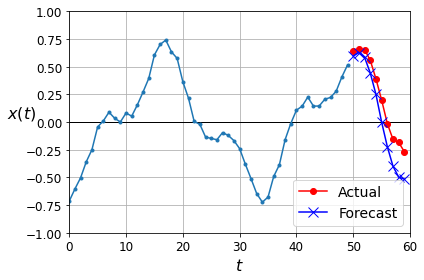

In [68]:
def plot_multiple_forecasts(X, Y, Y_pred):
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0,:,0])
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
  plt.plot(np.arange(n_steps, n_steps+ahead), Y_pred[0,:,0], "bx-", label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecats_ahead_plot")
plt.show()

2. RNN을 훈련하여 다음 값 10개를 한 번에 예측

1개가 아니라 값 10개를 출력 -> 타깃을 10개의 값이 담긴 벡터로 바꿔야 함

In [69]:
np.random.seed(42)

n_steps=50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:,0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:,0]

In [70]:
X = X_valid
for step_ahead in range(10):
  y_pred_one = model.predict(X)[:, np.newaxis, :]
  X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [71]:
Y_pred.shape

(2000, 10)

출력 층도 10개의 유닛을 가진 출력층 필요

In [72]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[50,1]),
  keras.layers.Dense(10)                                 
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0227 - val_loss: 0.0222

In [73]:
np.random.seed(42)

tf.random.set_seed(42)


model = keras.models.Sequential([

keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),

keras.layers.SimpleRNN(20),

keras.layers.Dense(10)

])


model.compile(loss="mse", optimizer="adam")

history = model.fit(X_train, Y_train, epochs=20,

validation_data=(X_valid, Y_valid))



Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0110 - val_lo

In [74]:
np.random.seed(43)

series = generate_time_series(1,50 +10)
X_new, Y_new = series[:,:50,:], series[:,-10,:]
Y_pred = model.predict(X_new)[...,np.newaxis]

In [75]:
Y_pred

array([[[ 0.5974749 ],
        [ 0.5974007 ],
        [ 0.5398125 ],
        [ 0.44681236],
        [ 0.3182176 ],
        [ 0.1789411 ],
        [ 0.06597404],
        [-0.00696771],
        [-0.06230196],
        [-0.1195098 ]]], dtype=float32)

IndexError: ignored

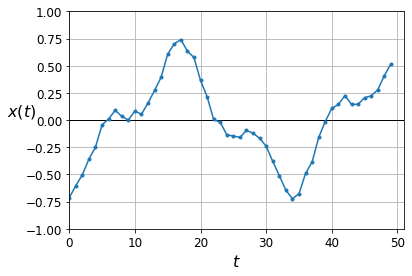

In [76]:
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

## LSTM

In [77]:
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:,-1],
                                          Y_pred[:,-1])

In [78]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]),
  keras.layers.LSTM(20, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(10))                                 
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20


InvalidArgumentError: ignored